# Project: Write a Data Science Blog Post Using CRISP-DM

## Section I. Business Understanding

**Introduction**: To investigate how Olympic athletes have changed over the years, I explored an Olympic Games data set from the Kaggle user rgriffin (https://www.kaggle.com/heesoo37/120-years-of-olympic-history-athletes-and-results) which includes data on the age, gender, height, weight, country of origin, and medals won. I restricted the data set to the summer games since 1980 and looked for interesting observations regaring the athletes over the past 40 years and found some thought provoking trends in the age and gender of recent Olympic athletes. 

**Question 1:** How does the number of athletes representing a country influence the number of medals won by that country? 

**Question 2:** Are there trends in the average age of athletes over time?

**Question 3:** What are the trends in the athlete gender?

# Section II. Data Understanding

Gather the data and gain some basic understanding of it.

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#set up the plot size default for better images
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

#df = pd.read_csv(csv_url)
Athletes_df = pd.read_csv(r"C:\Users\merwi\Desktop\Udacity DS files\Project I\athlete_events.csv")

print(Athletes_df.head())

print(Athletes_df.shape)

# check columns for null values. If there are nulls in the age column that can affect the conclusions drawn from averages. 
col_null = Athletes_df.columns[Athletes_df.isnull().any()==True].tolist()

# count the null values in these columns
print(Athletes_df[col_null].isnull().sum())


   ID                      Name Sex   Age  Height  Weight            Team  \
0   1                 A Dijiang   M  24.0   180.0    80.0           China   
1   2                  A Lamusi   M  23.0   170.0    60.0           China   
2   3       Gunnar Nielsen Aaby   M  24.0     NaN     NaN         Denmark   
3   4      Edgar Lindenau Aabye   M  34.0     NaN     NaN  Denmark/Sweden   
4   5  Christine Jacoba Aaftink   F  21.0   185.0    82.0     Netherlands   

   NOC        Games  Year  Season       City          Sport  \
0  CHN  1992 Summer  1992  Summer  Barcelona     Basketball   
1  CHN  2012 Summer  2012  Summer     London           Judo   
2  DEN  1920 Summer  1920  Summer  Antwerpen       Football   
3  DEN  1900 Summer  1900  Summer      Paris     Tug-Of-War   
4  NED  1988 Winter  1988  Winter    Calgary  Speed Skating   

                              Event Medal  
0       Basketball Men's Basketball   NaN  
1      Judo Men's Extra-Lightweight   NaN  
2           Football Men's

# Section III. Data Preparation

Subset the data and impute average by year into missing age values

In [58]:
#select the columns and parameters I want
Ath_df = Athletes_df[['ID','Sex','Age','NOC','Year','Sport','Season','Medal']]

Ath_df = Ath_df[Ath_df['Year'] >= 1980]

Ath_df = Ath_df[Ath_df['Season'] == 'Summer']

#There are missing values, 551 of them. I will impute the column average for that year whever the data is missing
Ath_df.Age = Ath_df.groupby('Year')['Age'].apply(lambda x: x.fillna(x.mean()))
Ath_df.Age = Ath_df.Age.fillna(Ath_df.Age.mean())
print (Ath_df)


            ID Sex   Age  NOC  Year       Sport  Season Medal
0            1   M  24.0  CHN  1992  Basketball  Summer   NaN
1            2   M  23.0  CHN  2012        Judo  Summer   NaN
31          12   M  31.0  FIN  2000   Badminton  Summer   NaN
32          13   F  30.0  FIN  1996     Sailing  Summer   NaN
33          13   F  34.0  FIN  2000     Sailing  Summer   NaN
...        ...  ..   ...  ...   ...         ...     ...   ...
271105  135565   M  23.0  ARG  2000      Hockey  Summer   NaN
271106  135565   M  27.0  ARG  2004      Hockey  Summer   NaN
271108  135567   M  24.0  RUS  2000      Rowing  Summer   NaN
271109  135567   M  28.0  RUS  2004      Rowing  Summer   NaN
271110  135568   F  33.0  BLR  2016  Basketball  Summer   NaN

[122913 rows x 8 columns]


Data preparation continued: Prep that data set for analysis by creating some aggreagate fields by gender and weight the medals by number and type. This will build the dataframe which will be used to address the three questions defined in Section I: Business Understanding.

In [59]:
#1. Create a numeric value for medals based on quality rank

# create a list of our conditions
conditions = [
    (Ath_df['Medal'] == 'Gold'),
    (Ath_df['Medal'] == 'Silver'),
    (Ath_df['Medal'] == 'Bronze')
    ]

# create a list of the values we want to assign for each condition
values = [3, 2, 1]

# create a new column and use np.select to assign values to it using our lists as arguments
Ath_df.loc[:,('numeric_medals')] = np.select(conditions, values)

#subset into male and female datasets
Ath_df_m = Ath_df[Ath_df['Sex'] == 'M']
Ath_df_f = Ath_df[Ath_df['Sex'] == 'F']
        
#now add up the medal numbers by country using this formula:  df['Data4'] = df['Data3'].groupby(df['Date']).transform('sum
Sum_m = Ath_df_m.groupby(['NOC','Year']).agg({'numeric_medals':'sum',
                                                 'ID':'count',
                                                 'Age':'mean'
                                                }).reset_index()

Sum_f = Ath_df_f.groupby(['NOC','Year']).agg({'numeric_medals':'sum',
                                                 'ID':'count',
                                                 'Age':'mean'
                                                }).reset_index()

merged_df = pd.merge(Sum_m, Sum_f, on=['NOC', 'Year'])
merged_df

#now rename columns
merged_df = merged_df.rename(columns={'numeric_medals_x':'medals_male',
                                      'ID_x':'male_athlete_count',
                                      'Age_x':'male_athlete_age',
                                      'numeric_medals_y':'medals_female',
                                      'ID_y':'female_athlete_count',
                                      'Age_y':'female_athlete_age',
                                     })

#Add Totals for both sexes
merged_df['Total_Athletes'] = merged_df['male_athlete_count']+merged_df['female_athlete_count']
merged_df['Total_Medals'] = merged_df['medals_male']+merged_df['medals_female']
merged_df['Average_Total_Ages'] = ((merged_df['male_athlete_count']*merged_df['male_athlete_age'])+(merged_df['female_athlete_count']*merged_df['female_athlete_age']))/(merged_df['male_athlete_count']+merged_df['female_athlete_count'])

#clean up a bit
merged_df = merged_df.round({'male_athlete_age': 1, 'female_athlete_age': 1, 'Average_Total_Ages': 1})   
merged_df

,NOC,Year,medals_male,male_athlete_count,male_athlete_age,medals_female,female_athlete_count,female_athlete_age,Total_Athletes,Total_Medals,Average_Total_Ages
0,AFG,2004,0,3,19.0,0,2,18.0,5,0,18.6
1,AFG,2008,1,3,22.7,0,1,22.0,4,1,22.5
2,AFG,2012,1,5,25.2,0,1,23.0,6,1,24.8
3,AFG,2016,0,2,27.0,0,1,20.0,3,0,24.7
4,AHO,1984,0,6,17.3,0,7,19.0,13,0,18.2
...,...,...,...,...,...,...,...,...,...,...,...
1537,ZIM,2000,0,18,27.0,0,8,20.4,26,0,25.0
1538,ZIM,2004,0,9,26.0,6,5,23.4,14,6,25.1
1539,ZIM,2008,0,8,26.5,9,8,25.6,16,9,26.1
1540,ZIM,2012,0,4,27.2,0,5,27.4,9,0,27.3


# Section IV. Model the Data

Do a linear regression model of the data fields for Total_Athletes and Total_Medals to 

In [60]:
#Is there a correlation between number of athletes and number of medals? 
import sklearn 
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression

#linear regression
X = merged_df.loc[:, 'Total_Athletes'].values.reshape(-1, 1)  # values converts it into a numpy array
Y = merged_df.loc[:, 'Total_Medals'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows; 1 column
Year = merged_df.loc[:, 'Year'].values.reshape(-1, 1)
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions


# Section V. Evaluate the Results

## Question 1. How does the number of athletes representing a country influence the number of medals won by that country?

<AxesSubplot:>

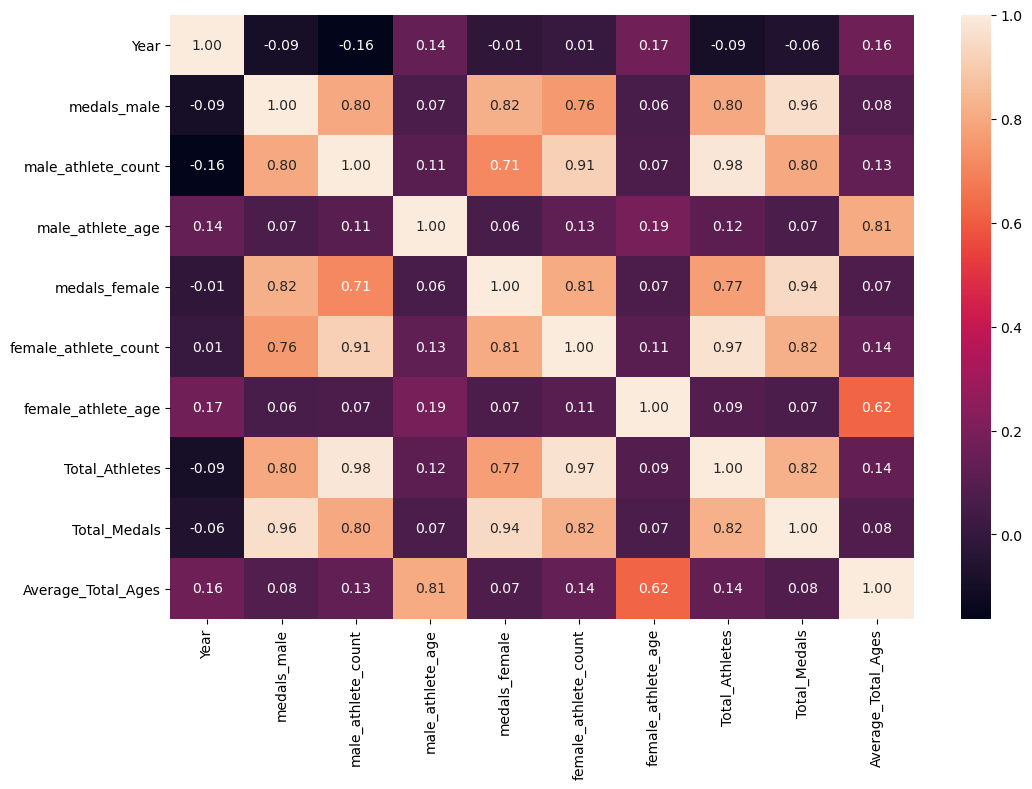

In [61]:
#check for correlations in the dataset
import seaborn as sns

#Visualization of correlations
#merged_df.corr() into a heatmap
sns.heatmap(merged_df.corr(), annot = True, fmt='.2f')

### Question 1: Explanation of correlogram

Observations from correlelogram in the cell above (note if you don't see a visual please run the cell before marking it as missing) can be used to answer the first question in Section I. Business Understanding. There is a positive correlation between the number of athletes and the total medals of 0.82. The correlation is positive, indicating that the as the number of athletes increases, the number of medals increases as well. The score of 0.82 indicates a strong correlation.

Further analysis for question 1: Visualize the correlation with a linear regression and scatterplot.

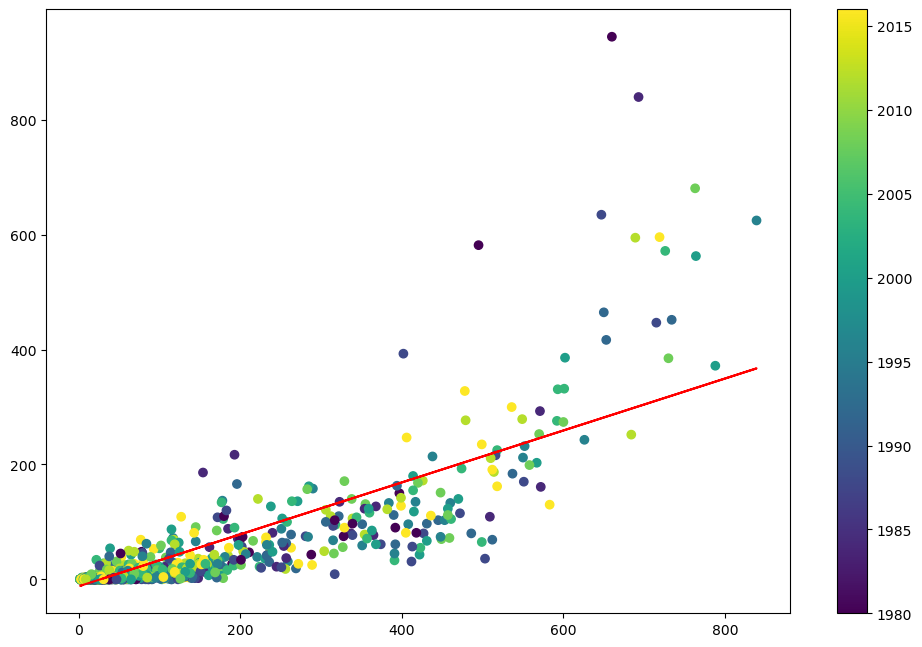

0.6795049111265645


In [62]:
#now visualize the linear regression on a scatter plot of the two variables. 

plt.scatter(X, Y, c=Year)
plt.plot(X, Y_pred, color='red')
plt.colorbar()
plt.show()

#find the coefficients
r2_test_linear = r2_score(Y, Y_pred) # Rsquared here
print(r2_test_linear)

### Question 1: Explanation of scatterplot

The scatterplot visualizes the correlation score clearly, with a best fit line revealing the positive trend in more athletes leading to more medals with a R squarred value of 0.68. Setting the color scale to the year of the Olympics indicates that the relationship has been fairly stable over time. 

## Question 2: Are there trends in the average age of athletes over time?

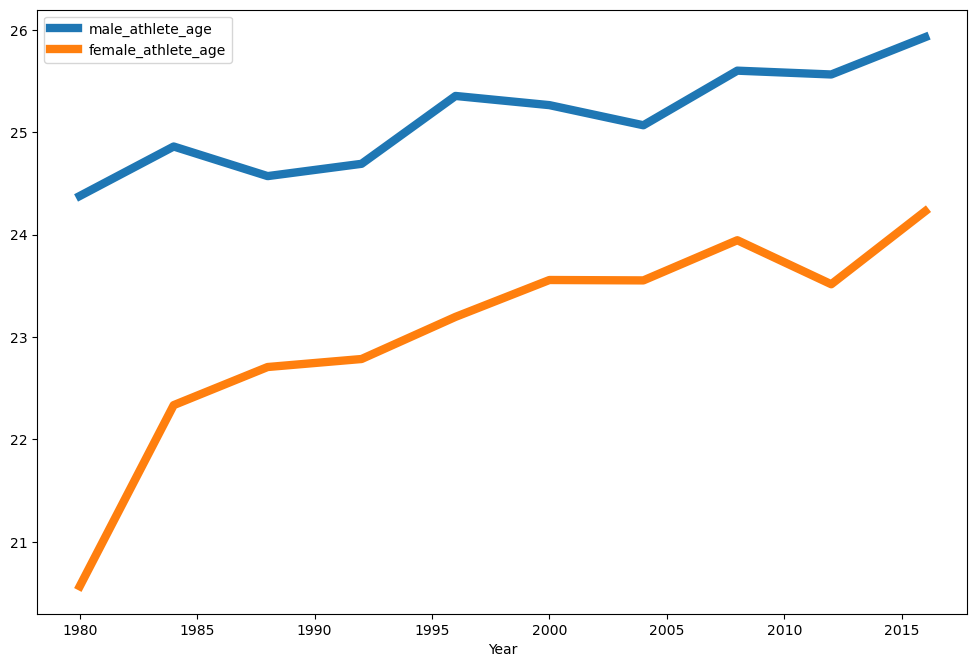

Average Male Age:  25.127495993261107
Average Feale Age:  23.038620286582294


In [63]:
#aggregate the dataset further to add % female by year and average athlete age by gender
Sum_by_year = merged_df.groupby(['Year']).agg({  'Total_Athletes':'sum',
                                               'male_athlete_count':'sum',
                                               'female_athlete_count':'sum',
                                                 'male_athlete_age':'mean',
                                                 'female_athlete_age':'mean',
                                                 'Average_Total_Ages':'mean'}).reset_index()

#add the % female column
Sum_by_year['%_female'] = Sum_by_year['female_athlete_count']/(Sum_by_year['male_athlete_count']+Sum_by_year['female_athlete_count'])*100

#plot the results
Sum_by_year.plot(x="Year", y=["male_athlete_age", "female_athlete_age"], linewidth=6)
plt.show()

#print the means
print("Average Male Age: ", Sum_by_year['male_athlete_age'].mean())
print("Average Feale Age: ", Sum_by_year['female_athlete_age'].mean())


### Question 2: Explanation of line plot above

The line plot above shows that the average age of athletes is increasing over time. It also shows that the average age is significantly and consistently different by gender, women being about 2.12 years younger than men. One possible answer is that the sports which attract move female athletes tend to favor younger athletes, for example where technique can be mastered while the body mass is relatively smaller. As a first looks at this possibility, the average age per sport was measured along with the distribution of the genders into that sport. There are indeed differences in age per sport and differences in the distribution of each gender in each sport. Further more, the product of the gender distribution and the average age by sport sum up to approximately the observed age differences (23.8 vs.23.3 for females and 25.0 vs. 25.3 for males).

## Question 3: What are the trends in the athlete gender?

The line plot above shows that the average age is significantly and consistently different by gender, women being about 2.12 years younger than men. One possible reason for this is that the sports which have more female athletes tend to favor younger athletes. To investigate this possibility, the average age per sport was measured along with the distribution of the genders into that sport. 

Expected Female Age by Sport:  23.836251457930288
Actual Female Age by Sport:  23.33249027237357
Expected Male Age by Sport:  24.995832052188796
Actual Male Age by Sport:  25.256939040207488


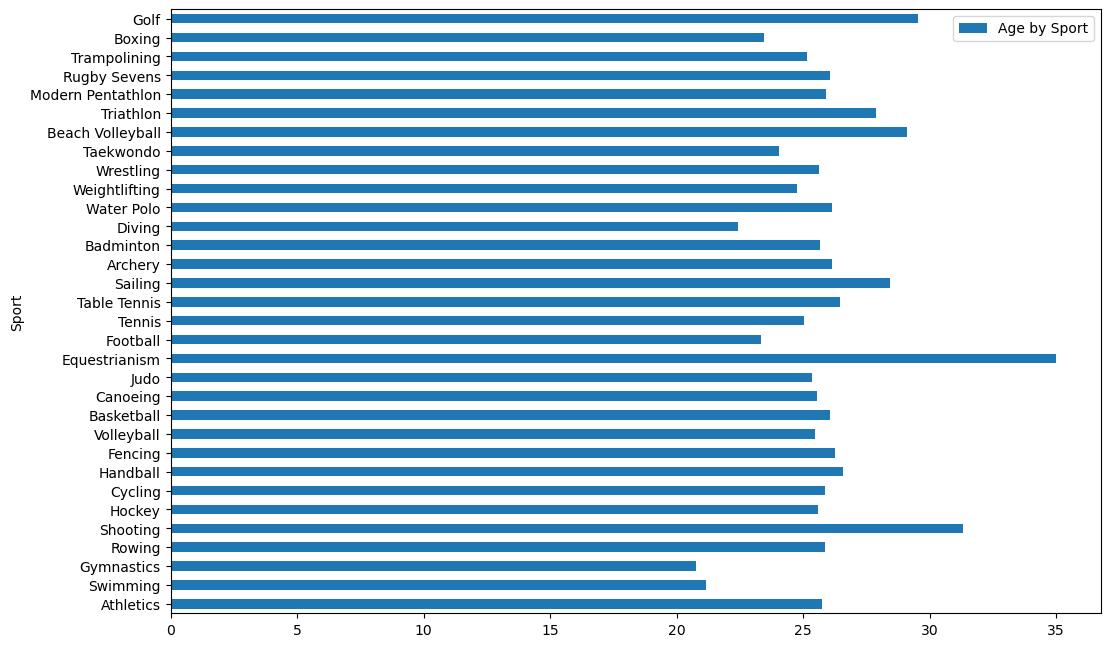

In [64]:
#Break down age by sport and then distribution of females by sport to see if that accounts for the age difference

#check the number of sports
status_vals = Ath_df.Sport.value_counts()
#print(status_vals)

Age_by_sport = Ath_df.groupby(['Sport']).agg({'Age':'mean'}).reset_index()
Age_by_sport

#Now find the distribution of athletes by gender into the different sports

#subset the Sports dataframe into male and female
Sport_f = Ath_df[Ath_df['Sex'] == 'F']
Sport_m = Ath_df[Ath_df['Sex'] == 'M']
        
#Now find distribution of each sex by sport
Sport_Dist_Fem = (Sport_f['Sport'].value_counts() / Sport_f.shape[0]).to_frame()
Sport_Dist_Masc = (Sport_m['Sport'].value_counts() / Sport_m.shape[0]).to_frame()

#convert the rownames to a column
Sport_Dist_Fem.index.name = 'Sport_Name'
Sport_Dist_Fem.reset_index(inplace=True)
Sport_Dist_Fem.columns = ['Sport', 'Distribution']

Sport_Dist_Masc.index.name = 'Sport_Name'
Sport_Dist_Masc.reset_index(inplace=True)
Sport_Dist_Masc.columns = ['Sport', 'Distribution']

#Merge into one table to compare, rename and round values 
merged_Sport_Dist_Gend = pd.merge(Sport_Dist_Fem, Sport_Dist_Masc, on=['Sport'])
merged_Sport_Dist_Gend = pd.merge(merged_Sport_Dist_Gend, Age_by_sport, on=['Sport'])
merged_Sport_Dist_Gend.columns = ['Sport', 'Dist_fem', 'Dist_masc', 'Average_Age']
merged_Sport_Dist_Gend

#add weighted averages column and sum up as expected age distribution, then compare that to actuals
merged_Sport_Dist_Gend['fem_Age_product'] = merged_Sport_Dist_Gend['Dist_fem']*merged_Sport_Dist_Gend['Average_Age']
merged_Sport_Dist_Gend['Male_Age_product'] = merged_Sport_Dist_Gend['Dist_masc']*merged_Sport_Dist_Gend['Average_Age']


# Show a visual comparison
plotdata = pd.DataFrame({
    "Age by Sport":merged_Sport_Dist_Gend['Average_Age'].to_list()
    #"% of male athletes":merged_Sport_Dist_Gend['Dist_fem'].to_list(),
    #"% of female athletes":merged_Sport_Dist_Gend['Dist_masc'].to_list()
    }, 
    index=merged_Sport_Dist_Gend['Sport']
)

# Plot a bar chart
plotdata.plot(kind="barh")

#view results
print("Expected Female Age by Sport: ", merged_Sport_Dist_Gend['fem_Age_product'].sum())
print("Actual Female Age by Sport: ", merged_df['female_athlete_age'].mean())
print("Expected Male Age by Sport: ", merged_Sport_Dist_Gend['Male_Age_product'].sum())
print("Actual Male Age by Sport: ", merged_df['male_athlete_age'].mean())


## Question 3: Explanation of analysis above

There are indeed differences in age per sport and differences in the distribution of each gender in each sport. Further more, the product of the gender distribution and the average age by sport sum up to approximately the observed age differences (23.8 vs.23.3 for females and 25.0 vs. 25.3 for males).

Question 3 additional analysis: Find the average age of gender by sport. 

                Sport   Age_Male  Age_Female  Fem_%_of_Male  Male_:_Female
0             Archery  26.617149   25.594267      -0.038429       1.105843
1           Athletics  25.762082   25.717221      -0.001741       1.433114
2           Badminton  26.315202   25.047297      -0.048181       0.968919
3          Basketball  26.362299   25.659628      -0.026654       1.206081
4    Beach Volleyball  29.895833   28.315217      -0.052871       1.043478
5              Boxing  23.372208   26.638889       0.139768      43.222222
6            Canoeing  25.548418   25.573684       0.000989       2.753509
7             Cycling  25.548679   26.899570       0.052875       3.047346
8              Diving  22.975765   21.854422      -0.048805       1.072109
9       Equestrianism  35.182199   34.631376      -0.015656       2.065448
10            Fencing  26.455900   25.908320      -0.020698       1.921418
11           Football  22.709690   24.909091       0.096849       2.613636
12               Golf  32

<AxesSubplot:xlabel='Sport'>

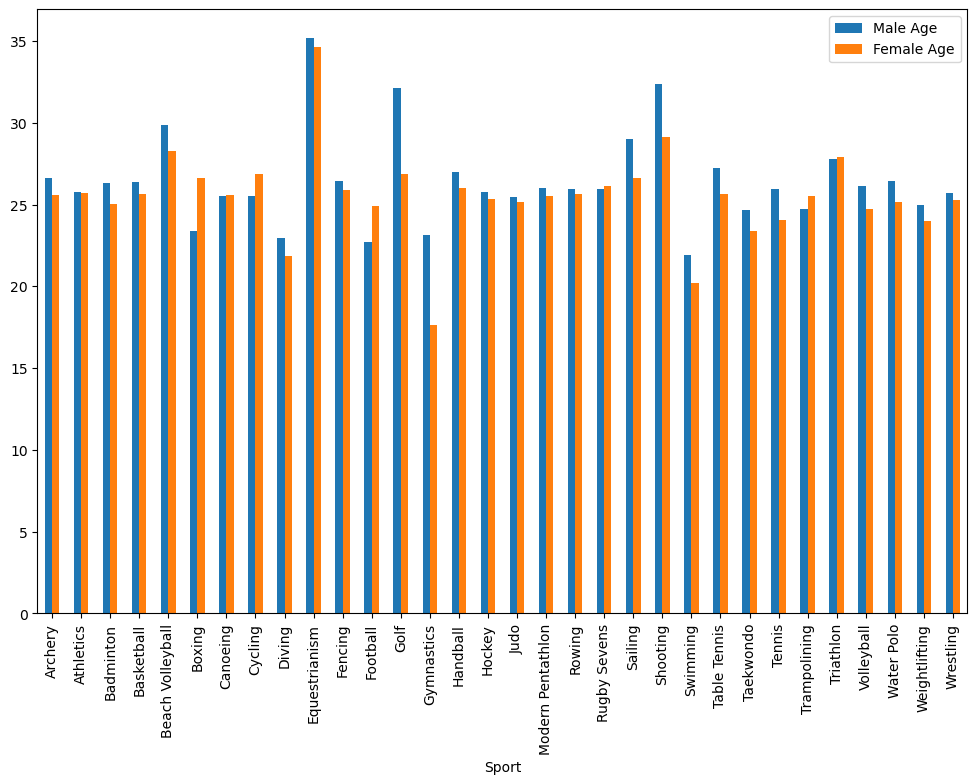

In [65]:
# check if the average age by sex within each sport is significantly different.
#Age_by_sport = Sports_df.groupby(['Sport']).agg({'Age':'mean'}).reset_index()
#Age_by_sport

#select the columns and parameters I want
Ath_df_sport = Athletes_df[['ID','Sex','Age','NOC','Year','Season','Medal','Sport']]
Ath_df_sport = Ath_df_sport[Ath_df_sport['Year'] >= 1980]
Ath_df_sport = Ath_df_sport[Ath_df_sport['Season'] == 'Summer']

#subset into male and female datasets
Ath_df_m = Ath_df_sport[Ath_df_sport['Sex'] == 'M']
Ath_df_f = Ath_df_sport[Ath_df_sport['Sex'] == 'F']

#Age_by_Sport_Act
Ath_df_m = Ath_df_m.groupby(['Sex','Sport']).agg({'ID':'count',
                                                 'Age':'mean'
                                                }).reset_index()

Ath_df_f = Ath_df_f.groupby(['Sex','Sport']).agg({'ID':'count',
                                                 'Age':'mean'
                                                }).reset_index()

merged_age_by_sport = pd.merge(Ath_df_m, Ath_df_f, on=['Sport'])
merged_age_by_sport.columns = ['Sex', 'Sport', 'Count_Male', 'Age_Male','Sex','Count_Female','Age_Female']

#add column representing female as % of male
merged_age_by_sport['Fem_%_of_Male'] = (merged_age_by_sport['Age_Female']-merged_age_by_sport['Age_Male'])/merged_age_by_sport['Age_Male']
merged_age_by_sport['Male_:_Female'] = (merged_age_by_sport['Count_Male']/merged_age_by_sport['Count_Female'])


#remove unnecessary columns
merged_age_by_sport = merged_age_by_sport[['Sport','Age_Male','Age_Female','Fem_%_of_Male','Male_:_Female']]
print(merged_age_by_sport)


# Show a visual comparison
plotdata = pd.DataFrame({
    "Male Age":merged_age_by_sport['Age_Male'].to_list(),
    "Female Age":merged_age_by_sport['Age_Female'].to_list()
    }, 
    index=merged_age_by_sport['Sport']
)

# Plot a bar chart
plotdata.plot(kind="bar")


## Question 3: Explanation of analysis above

The average age by gender for each sport shows that female athletes are indeed younger than their male counterparts across nearly all of the sports in the Olympic games.


Question 3 additional analysis: How has the percentage of female athletes changed over time.

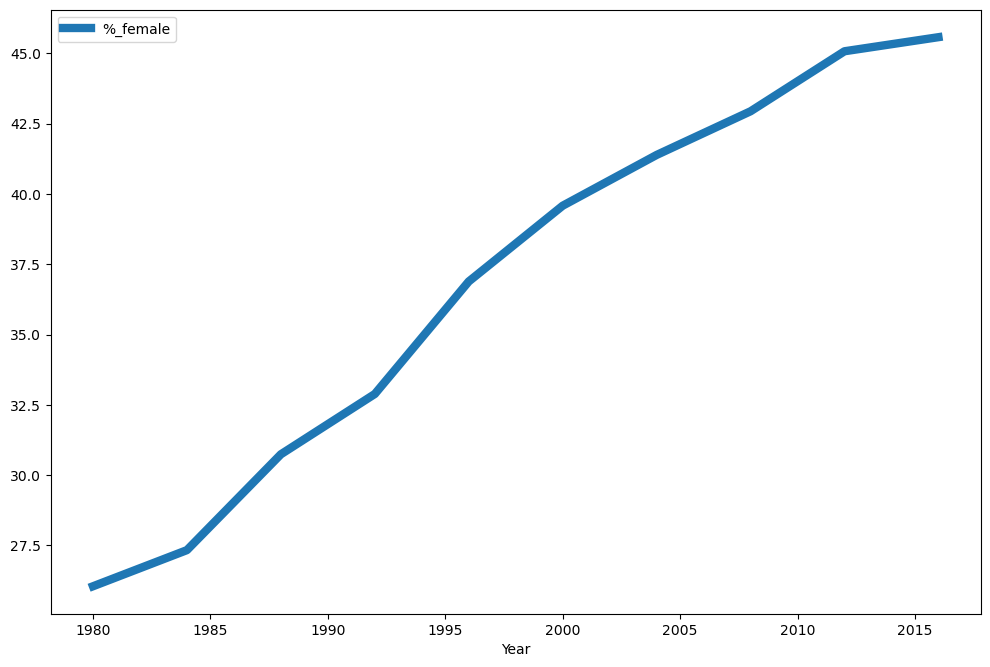

In [66]:
#plot the results
Sum_by_year.plot(x="Year", y=["%_female"], linewidth=6)
plt.show()

## Question 3: Explanation of line graph above

The percentage of athletes who are female has increased dramatically since the 80s. 